In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import torchvision.transforms as transforms
import  torch
import  numpy as np
import learn2learn as l2l
import matplotlib.pyplot as plt

from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
from learn2learn.data.utils import partition_task,  InfiniteIterator, OnDeviceDataset
from tqdm import tqdm 
from torch.utils.data import Dataset, DataLoader
from Miniimagenet import MiniImagenet as Mini
from torch import nn
from torch import optim
from torch.nn import functional as F
from MiniImagenet import miniImageNetGenerator as MiniImagenet

k_spt = 1
num_task = 100

train_set = Mini("/data01/jjlee_hdd/data", mode="train")
val_set = Mini("/data01/jjlee_hdd/data", mode="validation")
test_set = Mini("/data01/jjlee_hdd/data", mode="test")

train_dataset = l2l.data.MetaDataset(train_set)
val_dataset = l2l.data.MetaDataset(val_set)
test_dataset = l2l.data.MetaDataset(test_set)

train_transforms = [
   NWays(train_dataset, n = 5),
   KShots(train_dataset, k = 2),
   LoadData(train_dataset),
   # RemapLabels(train_dataset),
   ConsecutiveLabels(train_dataset)
   ]
val_transforms = [
   NWays(val_dataset, 5),
   KShots(val_dataset, 2),
   LoadData(val_dataset),
   # RemapLabels(val_dataset),
   # ConsecutiveLabels(val_dataset)
   ]
test_transforms = [
   NWays(test_dataset, 5),
   KShots(test_dataset, k_spt*2),
   LoadData(test_dataset),
   # RemapLabels(test_dataset),
   # ConsecutiveLabels(test_dataset)
   ]
    
train_tasks = l2l.data.TaskDataset(train_dataset, task_transforms = train_transforms, num_tasks=num_task)
val_tasks = l2l.data.TaskDataset(val_dataset, task_transforms = val_transforms, num_tasks=10)
test_tasks = l2l.data.TaskDataset(test_dataset, task_transforms = test_transforms, num_tasks=num_task)

train_loader = DataLoader(train_tasks,pin_memory=True, shuffle = True)
val_loader = DataLoader(val_tasks, pin_memory=True, shuffle = True)
test_loader = DataLoader(test_tasks, pin_memory=True, shuffle = True)



/home/jjlee/anaconda3/envs/MAML/lib/python3.9/site-packages/learn2learn/vision/benchmarks/omniglot_benchmark.py:7: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from PIL.Image import LANCZOS


In [3]:
x, y = next(iter(train_loader))


In [4]:
(x_spt, y_spt), (x_qry, y_qry) = partition_task(x[0], y[0], shots=k_spt)
print(y_spt)

tensor([ 3.,  5.,  8., 29., 43.], dtype=torch.float64)


In [4]:
model = torch.load("/home/jjlee/pretrain_network/embedding_model.pt")
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [2]:
model = torch.load("/home/jjlee/pretrain_network/embedding_model.pt")

device = torch.device("cuda")

train_results = []
labels = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(num_task), desc="check"):
        x, y = next(iter(train_loader))
        (x_spt, y_spt), (x_qry, y_qry) = partition_task(x[0], y[0], shots=k_spt)
        train_results.append(model(x_spt.to(device)).cpu().numpy())
        labels.append(y_spt)
            
train_results = np.array(train_results)
labels = np.array(labels)


check: 100%|██████████| 100/100 [00:04<00:00, 23.47it/s]
/tmp/ipykernel_3556930/1445616458.py:17: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  labels = np.array(labels)
/tmp/ipykernel_3556930/1445616458.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array(labels)


In [6]:
print(train_results.shape, labels.shape)


(100, 5, 2) (100,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


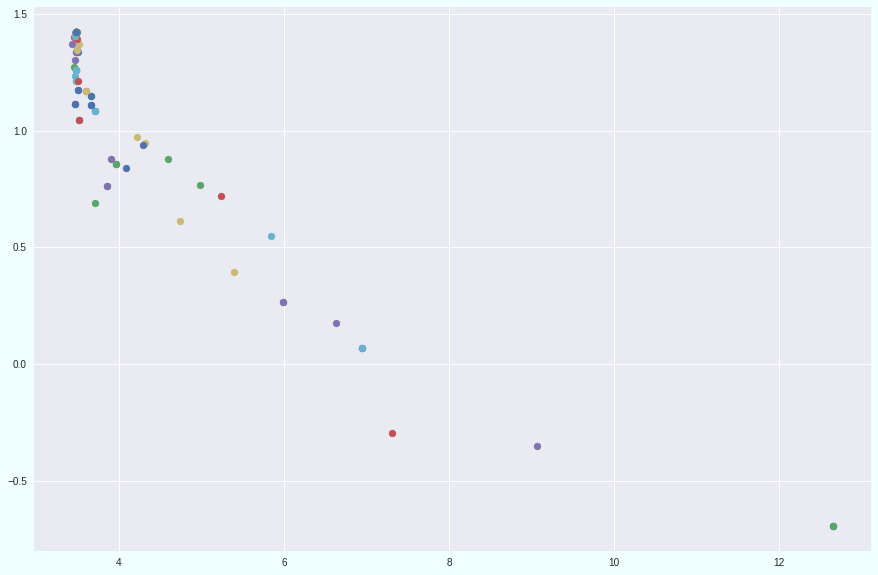

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(15, 10), facecolor="azure")
for i in range(train_results.shape[0]):
    tmp = train_results[i]
    # print(np.mean(tmp[:, 0]), tmp[:, 1] )
    plt.scatter(np.mean(tmp[:, 0]),np.mean(tmp[:, 1]))


plt.legend()
plt.show()

In [5]:
from xgboost import XGBClassifier
tree = XGBClassifier(seed=2020)
tree.fit(train_results, labels)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27], got [ 1.  6.  8. 10. 11. 18. 22. 23. 24. 25. 33. 35. 36. 37. 38. 39. 40. 42.
 46. 50. 51. 53. 54. 55. 58. 59. 60. 63.]

100%|██████████| 100/100 [00:03<00:00, 32.10it/s]


(500, 2)

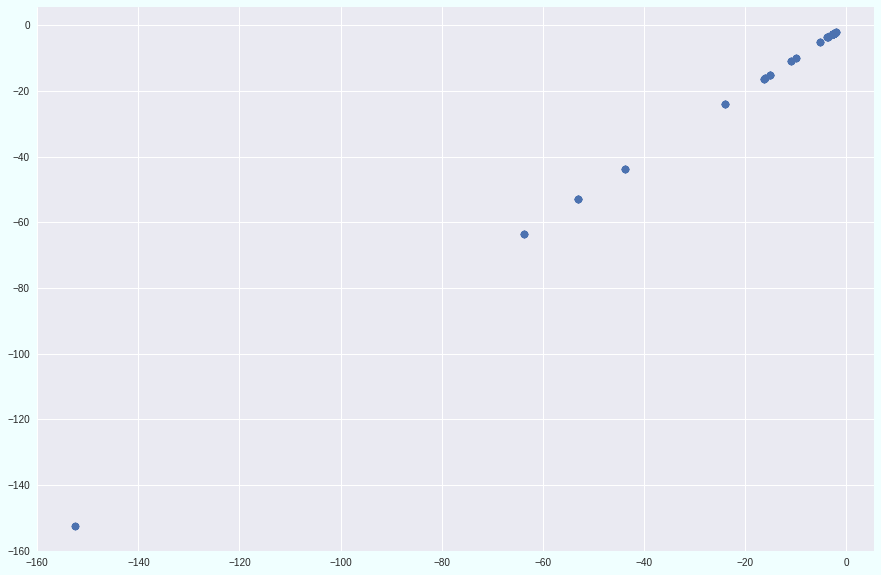

In [6]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in tqdm(range(100)):
        x, y = next(iter(val_loader))
        (x_spt, y_spt), (x_qry, y_qry) = partition_task(x[0], y[0], shots=k_spt)
        test_results.append(model(x_qry.to(device)).cpu().numpy())
        
test_results = np.concatenate(test_results)

plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 0], label=label)

test_results.shape